In [13]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from keras_flops import get_flops

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LSTM, Reshape, ConvLSTM2D, Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc

In [14]:
# Read and examine metadata
raw_data = pd.read_csv(r'../COVID-19 Lung CT Scan Segmentation/COVID-19 Lung CT Scan Segmentation/metadata_temp.csv')
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
3,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
8,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
1,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
6,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
11,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...


In [15]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [16]:
# Read sample
sample_ct   = read_nii(raw_data.loc[1,'ct_scan'])
sample_lung = read_nii(raw_data.loc[1,'lung_mask'])
sample_infe = read_nii(raw_data.loc[1,'infection_mask'])
sample_all  = read_nii(raw_data.loc[1,'lung_and_infection_mask'])

# Examine Shape
sample_ct.shape

(512, 512, 200)

Text(0.5, 1.0, 'Lung and Infection Mask')

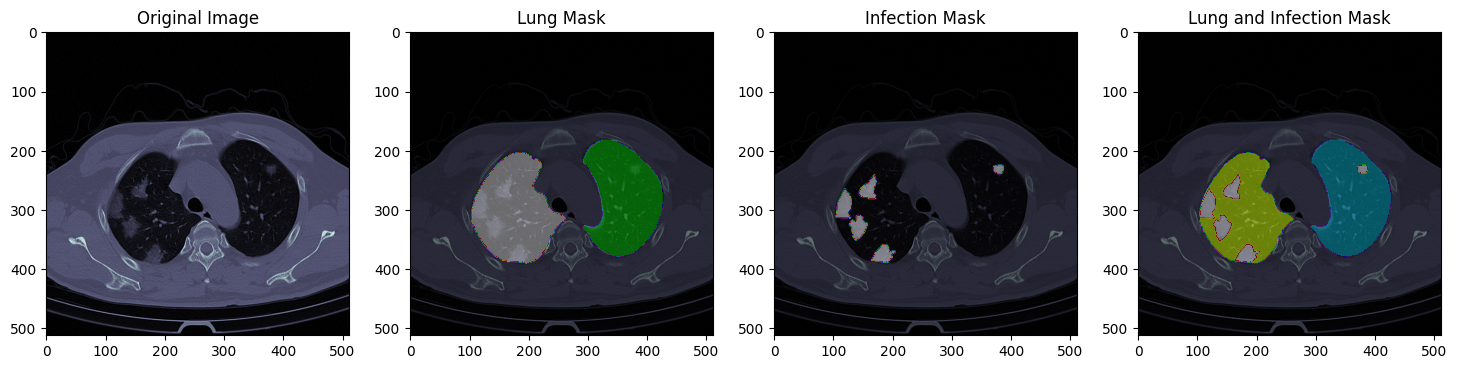

In [17]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [18]:
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 1

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def get_data():
    lungs_data = []
    infections_data  = []

    for row in range(len(raw_data)):
        lungs_image = read_nii(raw_data['ct_scan'][row])
        infection_image = read_nii(raw_data['infection_mask'][row])

        for slice_no in range(lungs_image.shape[2]):
            lung_slice = cv2.resize(lungs_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            infection_slice = cv2.resize(infection_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')

            lung_slice_temp = lung_slice.reshape(-1, 2)
            lung_slice_temp = scaler.fit_transform(lung_slice_temp)
            lung_slice = lung_slice_temp.reshape(lung_slice.shape)
            lungs_data.append(lung_slice[..., np.newaxis])

            infections_data.append(infection_slice[..., np.newaxis])
    return lungs_data, infections_data

In [20]:
data = get_data()
lungs = np.array(data[0])
infections = np.array(data[1])

Text(0.5, 1.0, 'Transformed Infection Mask')

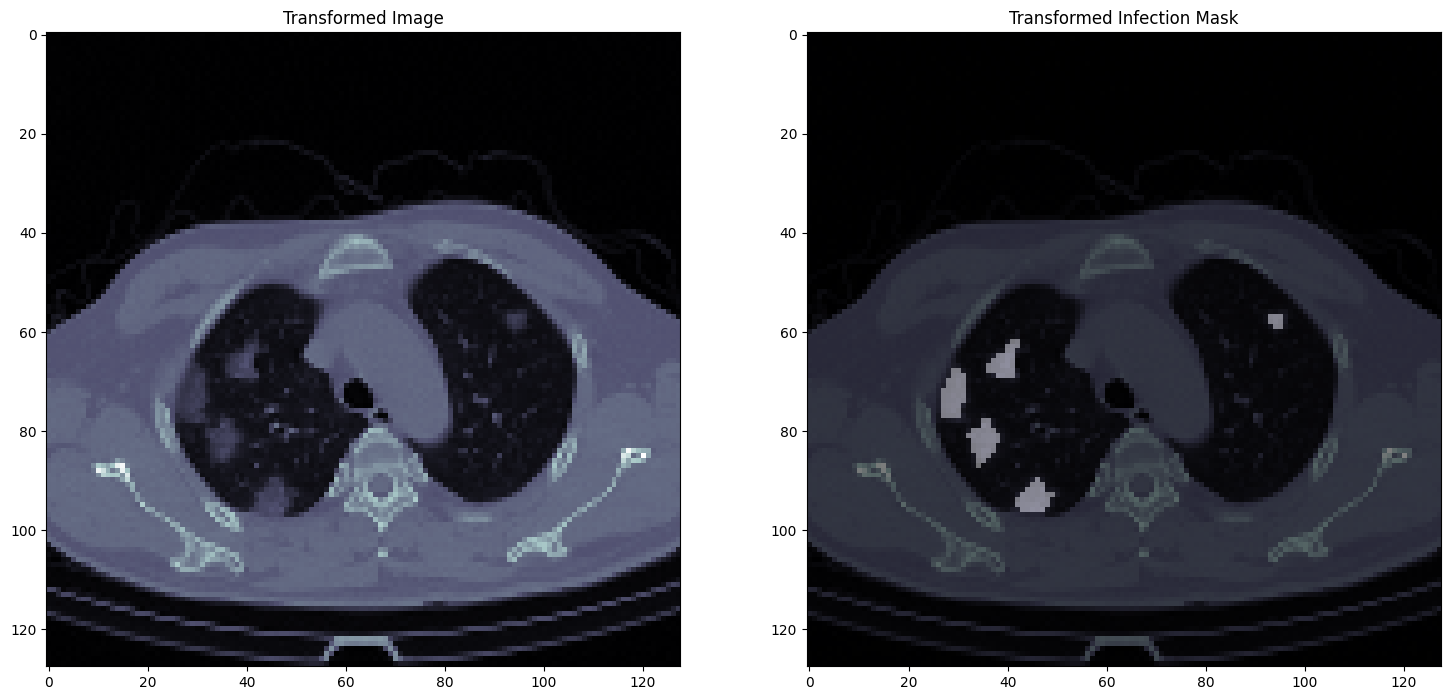

In [21]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
plt.imshow(lungs[451], cmap = 'bone')
plt.title('Transformed Image')

plt.subplot(1,2,2)
plt.imshow(lungs[451], cmap = 'bone')
plt.imshow(infections[451],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Transformed Infection Mask')

In [22]:
# Split the data into train and test sets
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size=0.1, shuffle=True)


In [23]:
def encoder_block(input_tensor, n_filters, kernel_size = 3):
    x = Conv2D(n_filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def decoder_block(input_tensor, skip_connections, n_filters, kernel_size = 3):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, skip_connections], axis=-1)

    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [24]:
def Unet(input_img, n_filters = 16, dropout=0.1):
    # Encoder Path
    lstm = tf.reshape(input_img, [-1, IMG_HEIGHT * IMG_WIDTH, IMG_CHANNELS])
    lstm = LSTM(256, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), return_sequences=True)(lstm)
    lstm = LSTM(512, return_sequences=True)(lstm)
    lstm = LSTM(256, return_sequences=True)(lstm)
    lstm = tf.reshape(input_img, [-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    e1 = encoder_block(input_img, n_filters * 1, kernel_size=3)
    p1 = MaxPooling2D((2, 2))(e1)
    p1 = Dropout(dropout)(p1)

    e2 = encoder_block(p1, n_filters * 2, kernel_size=3)
    p2 = MaxPooling2D((2, 2))(e2)
    p2 = Dropout(dropout)(p2)
    
    e3 = encoder_block(p2, n_filters * 4, kernel_size=3)
    p3 = MaxPooling2D((2, 2))(e3)
    p3 = Dropout(dropout)(p3)

    e4 = encoder_block(p3, n_filters * 8, kernel_size=3)
    p4 = MaxPooling2D((2, 2))(e4)
    p4 = Dropout(dropout)(p4)

    # Decoder Path
    d6 = decoder_block(p4, e4, n_filters * 8, kernel_size=3)
    d6 = Dropout(dropout)(d6)

    d7 = decoder_block(d6, e3, n_filters * 4, kernel_size=3)
    d7 = Dropout(dropout)(d7)

    d8 = decoder_block(d7, e2, n_filters * 2, kernel_size=3)
    d8 = Dropout(dropout)(d8)

    d9 = decoder_block(d8, e1, n_filters * 1, kernel_size=3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [25]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

In [26]:
from keras import backend as K
K.clear_session()

# Define the UNET model with TensorFlow's MeanIoU metric
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]  # Use MeanIoU as the Jaccard Index metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)  # Use custom Jaccard loss

gc.collect()

7211

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
]


In [29]:
results = model.fit(lung_train, infect_train, batch_size=8, epochs=50, callbacks=callbacks, validation_data=(lung_test, infect_test), use_multiprocessing=True)

Epoch 1/50
396/396 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9793 - auc: 0.8432 - sensitivity_at_specificity: 0.9124 - specificity_at_sensitivity: 0.9342 - mean_io_u: 0.4967
Epoch 1: val_loss improved from inf to 0.05801, saving model to model-Unet.h5
396/396 [==============================] - 33s 58ms/step - loss: 0.1789 - accuracy: 0.9793 - auc: 0.8432 - sensitivity_at_specificity: 0.9124 - specificity_at_sensitivity: 0.9342 - mean_io_u: 0.4967 - val_loss: 0.0580 - val_accuracy: 0.9939 - val_auc: 0.8792 - val_sensitivity_at_specificity: 0.8800 - val_specificity_at_sensitivity: 0.9975 - val_mean_io_u: 0.4969 - lr: 0.0010
Epoch 2/50
396/396 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9951 - auc: 0.9638 - sensitivity_at_specificity: 0.9610 - specificity_at_sensitivity: 0.9988 - mean_io_u: 0.4967
Epoch 2: val_loss improved from 0.05801 to 0.02179, saving model to model-Unet.h5
396/396 [==============================] - 23s 58ms/st

In [30]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
33,0.003290,0.998600,0.999206,0.998907,0.999990,0.496677,0.004197,0.998274,0.997333,0.995476,0.999952,0.496934,0.00010
32,0.003341,0.998584,0.999208,0.998927,0.999988,0.496677,0.004213,0.998262,0.997269,0.995363,0.999953,0.496934,0.00010
36,0.003195,0.998640,0.999205,0.998878,0.999992,0.496677,0.004217,0.998276,0.996643,0.994091,0.999958,0.496934,0.00010
39,0.003126,0.998669,0.999219,0.998884,0.999993,0.496677,0.004227,0.998291,0.996661,0.994119,0.999958,0.496934,0.00001
37,0.003132,0.998668,0.999326,0.999101,0.999993,0.496677,0.004228,0.998276,0.996404,0.993610,0.999958,0.496934,0.00001
38,0.003126,0.998667,0.999304,0.999055,0.999992,0.496677,0.004240,0.998277,0.996320,0.993440,0.999957,0.496934,0.00001
40,0.003119,0.998674,0.999258,0.998962,0.999992,0.496677,0.004251,0.998281,0.996137,0.993073,0.999961,0.496934,0.00001
35,0.003217,0.998631,0.999256,0.998985,0.999992,0.496677,0.004253,0.998264,0.996736,0.994288,0.999956,0.496934,0.00010
41,0.003111,0.998677,0.999236,0.998916,0.999992,0.496677,0.004263,0.998282,0.996066,0.992931,0.999959,0.496934,0.00001
43,0.003109,0.998683,0.999224,0.998890,0.999992,0.496677,0.004269,0.998279,0.996066,0.992931,0.999959,0.496934,0.00001


In [31]:
model.save("LSTM_UNet.h5")

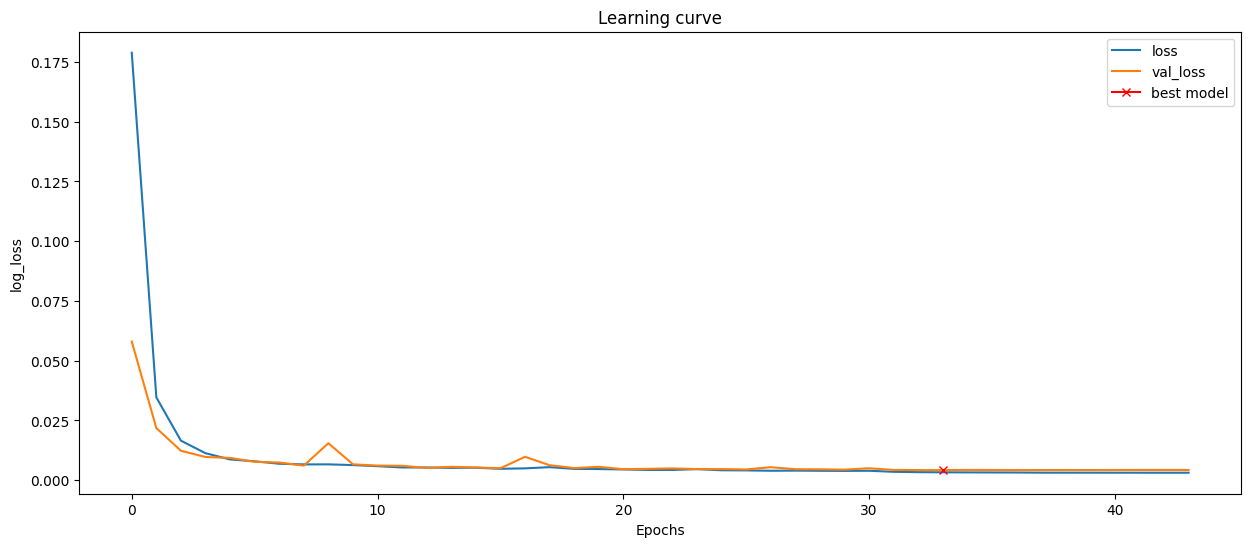

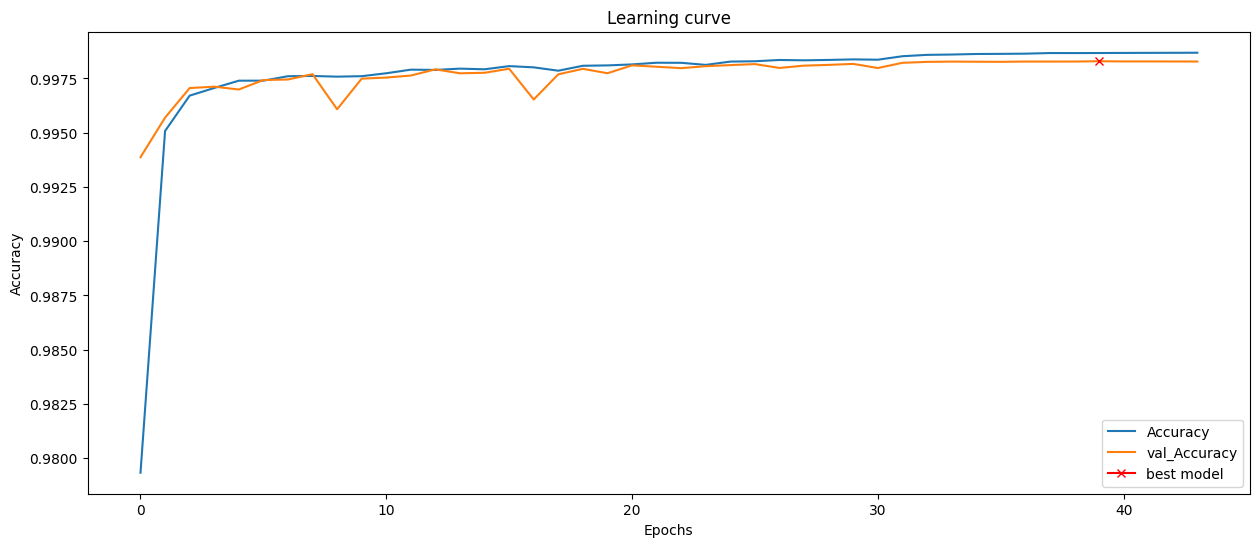

In [32]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
     

In [33]:
# Calculate metrics
predicted = model.predict(lung_test)

# Flatten the predicted and true masks
predicted_flat = np.round(predicted.flatten())
infect_test_flat = infect_test.flatten()

In [34]:
with tf.device("CPU"):
    # Calculate metrics for training data
    train_predicted = model.predict(lung_train)

    # Flatten the predicted and true masks
    train_predicted_flat = np.round(train_predicted.flatten())
    infect_train_flat = infect_train.flatten()

    # Calculate precision and recall for training data
    train_precision = Precision()
    train_recall = Recall()
    train_precision.update_state(infect_train_flat, train_predicted_flat)
    train_recall.update_state(infect_train_flat, train_predicted_flat)

    # Calculate F1 score for training data
    train_f1_score = 2 * (train_precision.result() * train_recall.result()) / (train_precision.result() + train_recall.result())

    # Calculate accuracy for training data
    train_accuracy = np.mean(train_predicted_flat == infect_train_flat)

    # Calculate metrics for testing data
    test_predicted = model.predict(lung_test)

    # Flatten the predicted and true masks for testing data
    test_predicted_flat = np.round(test_predicted.flatten())
    infect_test_flat = infect_test.flatten()

    # Calculate precision and recall for testing data
    test_precision = Precision()
    test_recall = Recall()
    test_precision.update_state(infect_test_flat, test_predicted_flat)
    test_recall.update_state(infect_test_flat, test_predicted_flat)

    # Calculate F1 score for testing data
    test_f1_score = 2 * (test_precision.result() * test_recall.result()) / (test_precision.result() + test_recall.result())

    # Calculate accuracy for testing data
    test_accuracy = np.mean(test_predicted_flat == infect_test_flat)

    # Calculate parameters
    total_parameters = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

    # Calculate FLOPs
    flops = get_flops(model, batch_size=1)  # Assuming batch_size = 1

    # Print the metrics for training data
    print("Training Metrics:")
    print("Precision: ", train_precision.result().numpy())
    print("Recall: ", train_recall.result().numpy())
    print("F1 Score: ", train_f1_score.numpy())
    print("Accuracy: ", train_accuracy)

    # Print the metrics for testing data
    print("\nTesting Metrics:")
    print("Precision: ", test_precision.result().numpy())
    print("Recall: ", test_recall.result().numpy())
    print("F1 Score: ", test_f1_score.numpy())
    print("Accuracy: ", test_accuracy)

    # Print the other metrics
    print("\nTotal Parameters: ", total_parameters)
    print("FLOPs: ", flops)


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Training Metrics:
Precision:  0.9110387
Recall:  0.8980483
F1 Score:  0.9044968
Accuracy:  0.9987395508120759

Testing Metrics:
Precision:  0.8645953
Recall:  0.8528855
F1 Score:  0.85870045
Accuracy:  0.9982787045565519

Total Parameters:  931553
FLOPs:  1559352968


In [35]:
with tf.device("CPU"):
    # Calculate Jaccard Index (MeanIoU) for training data
    train_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    train_iou.update_state(infect_train_flat, train_predicted_flat)
    train_mean_iou = train_iou.result().numpy()

    # Calculate Jaccard Index (MeanIoU) for testing data
    test_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    test_iou.update_state(infect_test_flat, test_predicted_flat)
    test_mean_iou = test_iou.result().numpy()

    # Print the Jaccard Index (MeanIoU) for training and testing data
    print("Training Jaccard Index (MeanIoU): ", train_mean_iou)
    print("Testing Jaccard Index (MeanIoU): ", test_mean_iou)


Training Jaccard Index (MeanIoU):  0.9108803
Testing Jaccard Index (MeanIoU):  0.875329


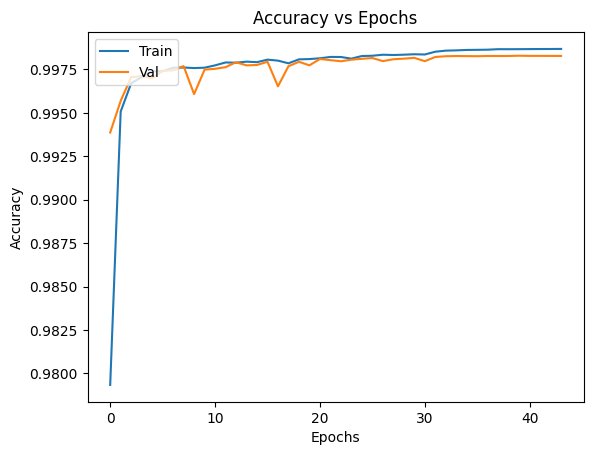

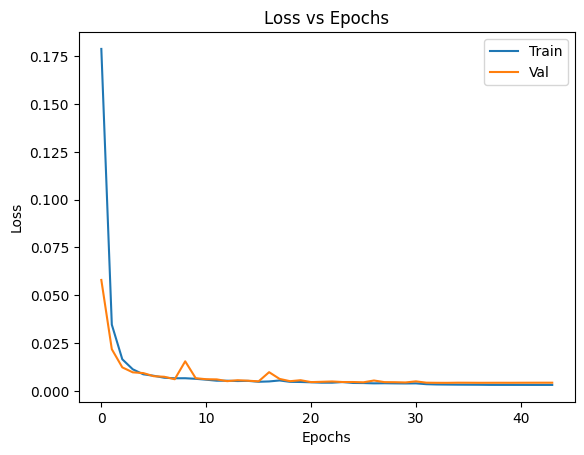

In [36]:
# Plot accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [37]:
# Make predictions
predicted = model.predict(lung_test)

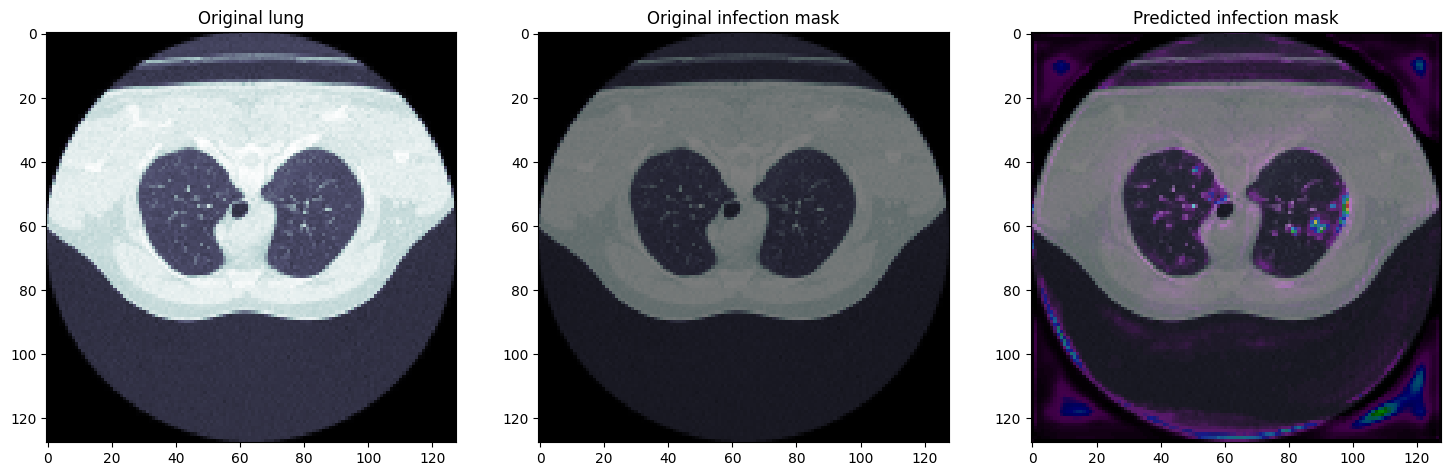

In [38]:
with tf.device("CPU"):
    # Make predictions and visualize
    img_num = 8
    predicted = model.predict(lung_test)

    # Visualize results
    fig = plt.figure(figsize=(18, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.title('Original lung')

    plt.subplot(1, 3, 2)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
    plt.title('Original infection mask')

    plt.subplot(1, 3, 3)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(predicted[img_num], alpha=0.5, cmap="nipy_spectral")
    plt.title('Predicted infection mask')

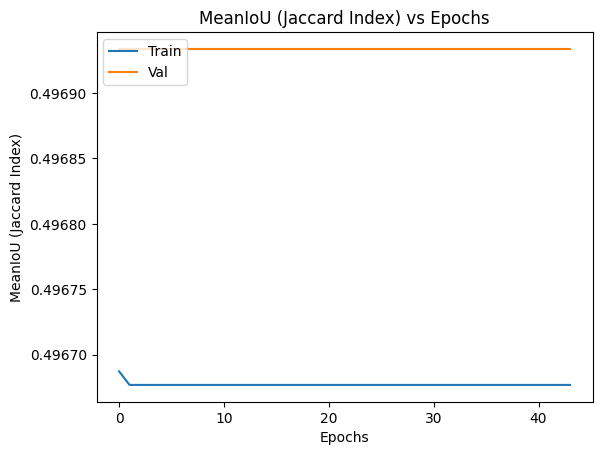

In [39]:
# Plot Jaccard Index (MeanIoU)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('MeanIoU (Jaccard Index) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU (Jaccard Index)')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()